In [1]:
#Load data and plot
DATASET_DIR = "/home/erdem/dataset/patches_urine_32_scaled"
CATEGORIES_ALL = ["Artifact", "BC", "cCry", "Dirt", "hCast", "LD", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "Unclassified", "WBC"]
CATEGORIES_INLIER = ["BC", "cCry", "hCast", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "WBC"]
CATEGORIES_OUTLIER = ["Artifact", "Dirt", "LD"]

In [2]:
import os
import cv2
import logging
import numpy as np
import methods
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow import keras
import seaborn as sns
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer, Flatten
from tqdm import tqdm
import albumentations as A

from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierAE
from alibi_detect.utils.fetching import fetch_detector
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

logger = tf.get_logger()
logger.setLevel(logging.ERROR)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [3]:
#Load data and plot
DATASET_DIR = "/home/erdem/dataset/patches_urine_32_scaled"
CATEGORIES_ALL = ["Artifact", "BC", "cCry", "Dirt", "hCast", "LD", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "Unclassified", "WBC"]
CATEGORIES_INLIER = ["BC", "cCry", "hCast", "nhCast", "nsEC", "RBC", "sCry", "sEC", "uCry", "WBC"]
CATEGORIES_OUTLIER = ["Artifact", "Dirt", "LD"]

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0, rotate_limit=90, scale_limit=[0,0.3], always_apply=True, p=1)
])

inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC"]
dim = (32, 32)
height, width = dim
transformed_cCry = methods.getTransformedImages("cCry", dim, transform, 200)
transformed_sCry = methods.getTransformedImages("sCry", dim, transform, 40)
transformed_uCry = methods.getTransformedImages("uCry", dim, transform, 40)
transformed_hCast = methods.getTransformedImages("hCast", dim, transform, 200)
transformed_nhCast = methods.getTransformedImages("nhCast", dim, transform, 200)
transformed_nsEC = methods.getTransformedImages("nsEC", dim, transform, 20)
transformed_sEC = methods.getTransformedImages("sEC", dim, transform, 20)
transformed_WBC = methods.getTransformedImages("WBC", dim, transform, 10)
transformed_RBC = methods.getTransformedImages("RBC", dim, transform, 10)
transformed_BC = methods.getTransformedImages("BC", dim, transform, 4)

transformed_all = np.concatenate((transformed_cCry, transformed_sCry, transformed_uCry, transformed_hCast, 
                                 transformed_nhCast, transformed_nsEC, transformed_sEC, transformed_WBC,
                                 transformed_RBC, transformed_BC))

testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers_loop = [testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC]
X_outliers_loop = [testImages_Artifact, testImages_Dirt, testImages_LD]

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [4]:
inlier_dataset = []
outlier_dataset = []

def createInlierData():
    for category in CATEGORIES_INLIER:
        path = os.path.join(DATASET_DIR,category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                inlier_dataset.append(img_array)
            except Exception as e:
                pass

def createOutlierData():
    for category in CATEGORIES_OUTLIER:
        path = os.path.join(DATASET_DIR,category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                outlier_dataset.append(img_array)
            except Exception as e:
                pass

In [5]:
createInlierData()
createOutlierData()

X_inlier = np.array(inlier_dataset).reshape(-1, 32, 32, 1)
X_inlier = X_inlier.astype('float32') / 255
# np.random.shuffle(X_inlier)

X_outlier = np.array(outlier_dataset).reshape(-1, 32, 32, 1)
X_outlier = X_outlier.astype('float32') / 255
# np.random.shuffle(X_outlier)

print(X_inlier.shape)
print(X_outlier.shape)

(21416, 32, 32, 1)
(113, 32, 32, 1)


In [7]:
encoding_dim = 256

encoder_net = tf.keras.Sequential(
[
    layers.InputLayer(input_shape=(32,32, 1)),
    layers.Conv2D(32, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2D(64, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2D(128, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Flatten(),
    layers.Dense(encoding_dim,)
])
encoder_net.summary()

decoder_net = tf.keras.Sequential(
[
    layers.InputLayer(input_shape=(encoding_dim,)),
    layers.Dense(4*4*128),
    layers.Reshape(target_shape=(4, 4, 128)),
    layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2DTranspose(1, (3,3), strides=2, padding='same', activation='sigmoid')
])
decoder_net.summary()

autoencoder_input = keras.Input(shape=(32, 32, 1), name="img")
encoded_img = encoder_net(autoencoder_input)
decoded_img = decoder_net(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary() 


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
Total params: 617,216
Trainable params: 617,216
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)              

In [8]:
autoencoder.compile(keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MeanSquaredError())
# Trained total 1000 epochs (or more)
history = autoencoder.fit(X_inlier, X_inlier,
                epochs=500,
                batch_size=64,
                shuffle = True,
                validation_split=0.2
               )

Epoch 1/500
268/268 [==============================] - 5s 11ms/step - loss: 0.0126 - val_loss: 0.0159
Epoch 2/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0071 - val_loss: 0.0125
Epoch 3/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0049 - val_loss: 0.0074
Epoch 4/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0031 - val_loss: 0.0056
Epoch 5/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0025 - val_loss: 0.0046
Epoch 6/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0021 - val_loss: 0.0039
Epoch 7/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 8/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 9/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 10/500
268/268 [==============================] - 2s 8ms/step - loss: 0.0013 - val_l

268/268 [==============================] - 2s 9ms/step - loss: 2.3207e-04 - val_loss: 4.1911e-04
Epoch 152/500
268/268 [==============================] - 3s 9ms/step - loss: 2.3624e-04 - val_loss: 4.1592e-04
Epoch 153/500
268/268 [==============================] - 3s 9ms/step - loss: 2.3214e-04 - val_loss: 4.1686e-04
Epoch 154/500
268/268 [==============================] - 3s 9ms/step - loss: 2.2687e-04 - val_loss: 4.2088e-04
Epoch 155/500
268/268 [==============================] - 2s 9ms/step - loss: 2.2881e-04 - val_loss: 4.1153e-04
Epoch 156/500
268/268 [==============================] - 3s 9ms/step - loss: 2.2554e-04 - val_loss: 4.0945e-04
Epoch 157/500
268/268 [==============================] - 3s 9ms/step - loss: 2.3446e-04 - val_loss: 4.0688e-04
Epoch 158/500
268/268 [==============================] - 3s 9ms/step - loss: 2.2354e-04 - val_loss: 4.0574e-04
Epoch 159/500
268/268 [==============================] - 3s 9ms/step - loss: 2.2318e-04 - val_loss: 4.0606e-04
Epoch 160/500
2

Epoch 225/500
268/268 [==============================] - 3s 9ms/step - loss: 1.9931e-04 - val_loss: 3.3196e-04
Epoch 226/500
268/268 [==============================] - 2s 9ms/step - loss: 1.9755e-04 - val_loss: 3.3568e-04
Epoch 227/500
268/268 [==============================] - 2s 9ms/step - loss: 1.9387e-04 - val_loss: 3.3042e-04
Epoch 228/500
268/268 [==============================] - 2s 9ms/step - loss: 1.9240e-04 - val_loss: 3.3216e-04
Epoch 229/500
268/268 [==============================] - 2s 9ms/step - loss: 1.9223e-04 - val_loss: 3.3373e-04
Epoch 230/500
268/268 [==============================] - 3s 9ms/step - loss: 1.9441e-04 - val_loss: 3.2748e-04
Epoch 231/500
268/268 [==============================] - 3s 9ms/step - loss: 1.9083e-04 - val_loss: 3.2684e-04
Epoch 232/500
268/268 [==============================] - 3s 9ms/step - loss: 1.9286e-04 - val_loss: 3.2532e-04
Epoch 233/500
268/268 [==============================] - 3s 9ms/step - loss: 1.9308e-04 - val_loss: 3.3390e-04
E

Epoch 299/500
268/268 [==============================] - 3s 9ms/step - loss: 1.6886e-04 - val_loss: 2.8039e-04
Epoch 300/500
268/268 [==============================] - 2s 9ms/step - loss: 1.6912e-04 - val_loss: 2.7903e-04
Epoch 301/500
268/268 [==============================] - 3s 9ms/step - loss: 1.6881e-04 - val_loss: 2.8082e-04
Epoch 302/500
268/268 [==============================] - 3s 10ms/step - loss: 1.6865e-04 - val_loss: 2.7983e-04
Epoch 303/500
268/268 [==============================] - 3s 9ms/step - loss: 1.6946e-04 - val_loss: 2.7873e-04
Epoch 304/500
268/268 [==============================] - 3s 9ms/step - loss: 1.6990e-04 - val_loss: 2.7714e-04
Epoch 305/500
268/268 [==============================] - 3s 9ms/step - loss: 1.7356e-04 - val_loss: 2.7761e-04
Epoch 306/500
268/268 [==============================] - 3s 9ms/step - loss: 1.6390e-04 - val_loss: 2.7844e-04
Epoch 307/500
268/268 [==============================] - 2s 9ms/step - loss: 1.6558e-04 - val_loss: 2.7906e-04


Epoch 373/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5178e-04 - val_loss: 2.5032e-04
Epoch 374/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5258e-04 - val_loss: 2.4612e-04
Epoch 375/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5689e-04 - val_loss: 2.4615e-04
Epoch 376/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5062e-04 - val_loss: 2.4895e-04
Epoch 377/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5035e-04 - val_loss: 2.4609e-04
Epoch 378/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5222e-04 - val_loss: 2.4580e-04
Epoch 379/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5147e-04 - val_loss: 2.4854e-04
Epoch 380/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5328e-04 - val_loss: 2.4560e-04
Epoch 381/500
268/268 [==============================] - 3s 9ms/step - loss: 1.5043e-04 - val_loss: 2.4605e-04
E

Epoch 447/500
268/268 [==============================] - 3s 9ms/step - loss: 1.4380e-04 - val_loss: 2.2723e-04
Epoch 448/500
268/268 [==============================] - 2s 9ms/step - loss: 1.4396e-04 - val_loss: 2.2632e-04
Epoch 449/500
268/268 [==============================] - 2s 9ms/step - loss: 1.4094e-04 - val_loss: 2.2651e-04
Epoch 450/500
268/268 [==============================] - 2s 9ms/step - loss: 1.4362e-04 - val_loss: 2.2732e-04
Epoch 451/500
268/268 [==============================] - 3s 9ms/step - loss: 1.4578e-04 - val_loss: 2.2553e-04
Epoch 452/500
268/268 [==============================] - 3s 9ms/step - loss: 1.4221e-04 - val_loss: 2.2985e-04
Epoch 453/500
268/268 [==============================] - 3s 9ms/step - loss: 1.4376e-04 - val_loss: 2.2602e-04
Epoch 454/500
268/268 [==============================] - 3s 9ms/step - loss: 1.4170e-04 - val_loss: 2.2665e-04
Epoch 455/500
268/268 [==============================] - 3s 9ms/step - loss: 1.4181e-04 - val_loss: 2.2587e-04
E

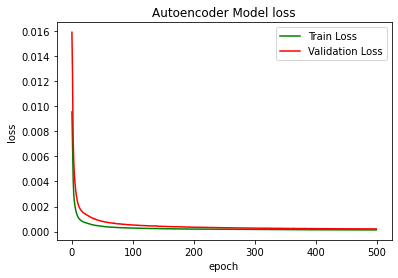

In [16]:
plt.plot(history.history['loss'], 'g', label='Train Loss')
plt.plot(history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Autoencoder Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

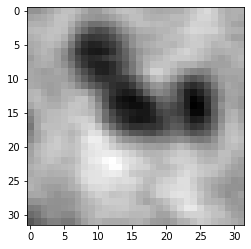

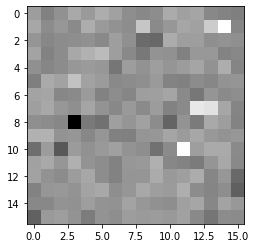

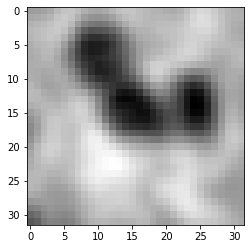

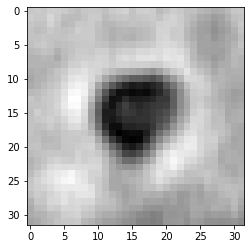

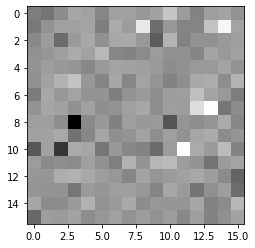

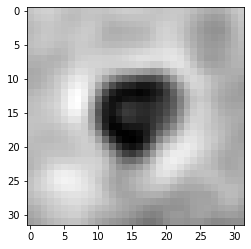

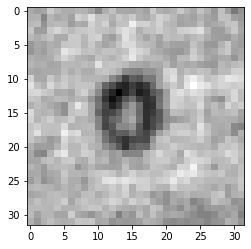

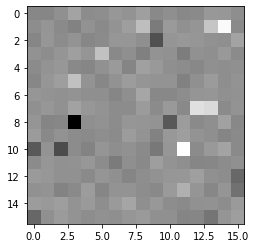

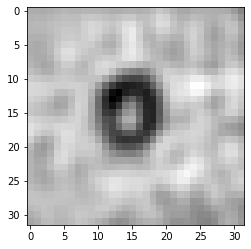

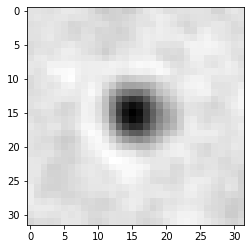

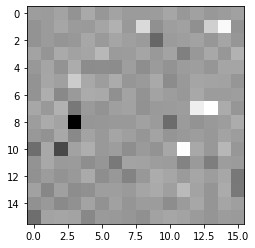

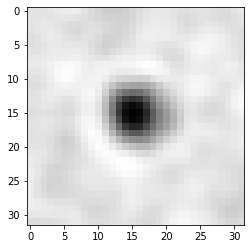

In [12]:
idx = 2094
X = X_inlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net.predict(X)
X_recon = decoder_net.predict(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1004
X = X_inlier[idx].reshape(1, 32,32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1002
X = X_inlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 1000
X = X_inlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()

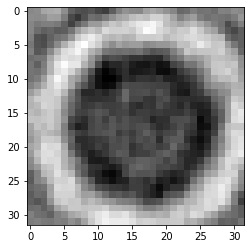

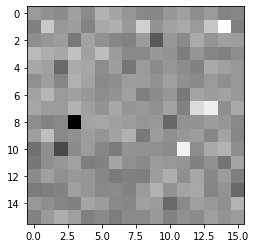

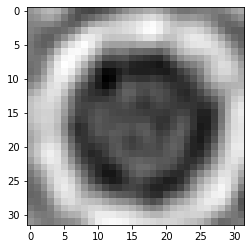

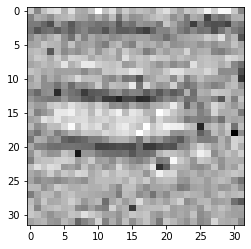

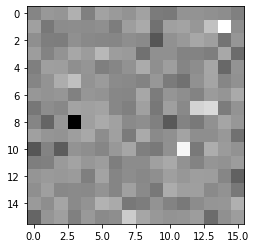

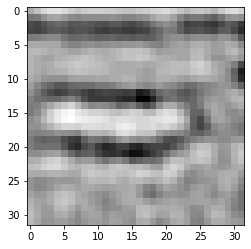

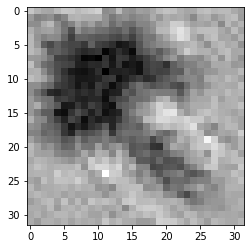

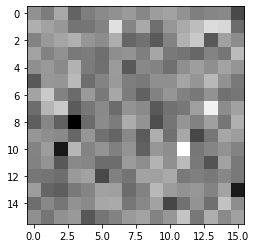

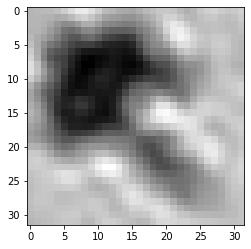

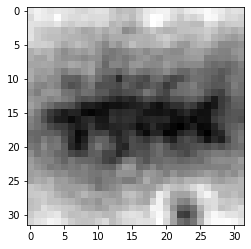

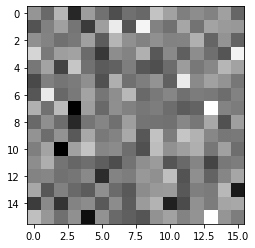

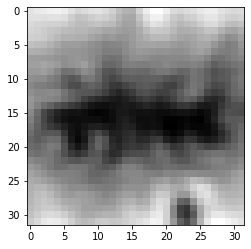

In [13]:
idx = 10
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net.predict(X)
X_recon = decoder_net.predict(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 2
X = X_outlier[idx].reshape(1, 32,32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 54
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()
idx = 78
X = X_outlier[idx].reshape(1, 32, 32, 1)
# X_recon = autoencoder.predict(X)
X_encoded = encoder_net(X)
X_recon = decoder_net(X_encoded)
plt.imshow(X.reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(X_encoded.numpy().reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(X_recon.numpy().reshape(32, 32, 1), cmap="gray")
plt.show()

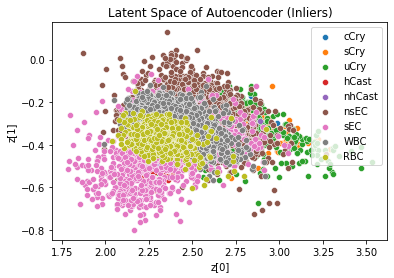

In [103]:
i = 0
for inlier in X_inliers_loop:
    encoded = encoder_net.predict(inlier)
    a = sns.scatterplot(x=encoded[:, 0], y=encoded[:, 1], label=inlier_names[i])
    i += 1
    plt.title('Latent Space of Autoencoder (Inliers)')
    # Set x-axis label
    plt.xlabel('z[0]')
    # Set y-axis label
    plt.ylabel('z[1]')
#     plt.xlim(-15, 8)
#     plt.ylim(-10, 20)

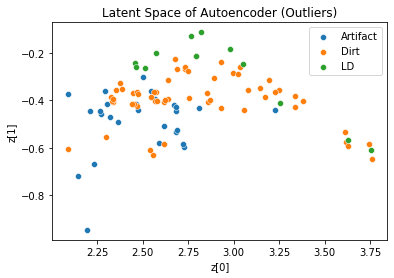

In [104]:
i = 0
for inlier in X_outliers_loop:
    encoded = encoder_net.predict(inlier)
    a = sns.scatterplot(x=encoded[:, 0], y=encoded[:, 1], label=CATEGORIES_OUTLIER[i])
    i += 1
    plt.title('Latent Space of Autoencoder (Outliers)')
    # Set x-axis label
    plt.xlabel('z[0]')
    # Set y-axis label
    plt.ylabel('z[1]')
#     plt.xlim(-15, 8)
#     plt.ylim(-10, 20)

In [ ]:
i = 0
for inlier in X_outliers_loop:
    X_recon, X_z, X_z_mean, X_z_log_var = vae(inlier)
    a = sns.scatterplot(x=X_z[:, 0], y=X_z[:, 1], label=CATEGORIES_OUTLIER[i])
    i += 1
    plt.title('Latent Space')
    # Set x-axis label
    plt.xlabel('z[0]')
    # Set y-axis label
    plt.ylabel('z[1]')

In [18]:
# Model Save
path = 'encoder_net'
encoder_net.save(path)
path = 'decoder_net'
decoder_net.save(path)